In [18]:
import os, cv2, json, warnings, numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils import LOGGER
from mmpose.apis import init_model as init_pose_estimator, inference_topdown
from mmpose.structures import merge_data_samples

warnings.filterwarnings("ignore", category=UserWarning)
LOGGER.setLevel("ERROR")

def run_sapiens_with_yolo_fixedbox(
    input_mp4,
    output_dir,
    pose_config,
    pose_checkpoint,
    device="cuda:0",
    duration_calib=30,   # YOLO-pose로 bbox 추출할 구간 (초)
    duration_pose=60,    # pose estimation 실행할 구간 (초)
    margin_ratio=0.2
):
    os.makedirs(output_dir, exist_ok=True)
    basename = os.path.splitext(os.path.basename(input_mp4))[0]
    output_json = os.path.join(output_dir, f"{basename}_sapiens.json")
    output_mp4  = os.path.join(output_dir, f"{basename}_sapiens.mp4")

    # -------------------------
    # 1) YOLOv11-pose로 30초간 bbox 추출 → median bbox 계산
    # -------------------------
    yolo_pose = YOLO("yolo11n-pose.pt")
    cap = cv2.VideoCapture(input_mp4)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_limit = int(min(total_frames, fps * duration_calib))
    bbox_list = []

    for _ in tqdm(range(frame_limit), desc="YOLO-Pose Calibration (BBox)"):
        ret, frame = cap.read()
        if not ret:
            break
        results = yolo_pose(frame, verbose=False)
        for r in results:
            for kp in r.keypoints.xy:
                x_coords = kp[:, 0].cpu().numpy()
                y_coords = kp[:, 1].cpu().numpy()
                if len(x_coords) == 0 or len(y_coords) == 0:
                    continue
                x1, y1, x2, y2 = int(x_coords.min()), int(y_coords.min()), int(x_coords.max()), int(y_coords.max())
                bw, bh = x2 - x1, y2 - y1
                x1 = max(0, int(x1 - bw * margin_ratio))
                y1 = max(0, int(y1 - bh * margin_ratio))
                x2 = min(orig_w, int(x2 + bw * margin_ratio))
                y2 = min(orig_h, int(y2 + bh * margin_ratio))
                bbox_list.append([x1, y1, x2, y2])
    cap.release()

    if not bbox_list:
        raise RuntimeError("YOLOv11-pose로부터 bbox를 얻지 못했습니다.")
    fixed_box = tuple(np.median(np.array(bbox_list), axis=0).astype(int))
    print(f"[INFO] 고정된 BBox: {fixed_box}")

    # -------------------------
    # 2) Sapiens Pose Estimator 초기화
    # -------------------------
    pose_estimator = init_pose_estimator(
        pose_config,
        pose_checkpoint,
        device=device,
        cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False))),
    )

    # joint name / skeleton 정보 자동 로드
    if "keypoint_info" in pose_estimator.dataset_meta:
        joint_names = [v["name"] for v in pose_estimator.dataset_meta["keypoint_info"].values()]
    elif "keypoint_labels" in pose_estimator.dataset_meta:
        joint_names = pose_estimator.dataset_meta["keypoint_labels"]
    else:
        joint_names = [f"kpt_{i}" for i in range(pose_estimator.cfg.model.head.out_channels)]
    skeleton_info = pose_estimator.dataset_meta.get("skeleton_info", {})

    # -------------------------
    # 3) Pose Estimation (고정 bbox, 앞 60초)
    # -------------------------
    cap = cv2.VideoCapture(input_mp4)
    frame_limit = int(min(total_frames, fps * duration_pose))

    resize_w, resize_h = 1280, 720
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_mp4, fourcc, fps, (resize_w, resize_h))

    all_keypoints = {}

    for frame_idx in tqdm(range(frame_limit), desc="Sapiens Pose Estimation"):
        ret, frame = cap.read()
        if not ret:
            break

        x1, y1, x2, y2 = fixed_box
        bboxes_np = np.array([[x1, y1, x2, y2]], dtype=np.float32)  # (1,4)

        pose_results = inference_topdown(pose_estimator, frame, bboxes_np)
        data_sample  = merge_data_samples(pose_results)

        inst = data_sample.get("pred_instances", None)
        if inst is not None and len(inst.get("keypoints", [])) > 0:
            kpts = inst["keypoints"][0].tolist()  # (K,2)

            # JSON 저장용 dict (conf 없이 좌표만 저장)
            frame_dict = {joint_names[i]: kpts[i] for i in range(len(joint_names))}
            all_keypoints[f"frame_{frame_idx:06d}"] = frame_dict

            # --- skeleton overlay (score 없이도 무조건 그림) ---
            kpts_arr = np.array(kpts)  # (K,2)

            # 점
            for (x, y) in kpts_arr:
                cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 0), -1)

            # 선
            for sk in skeleton_info.values():
                i, j = sk["link"]
                xi, yi = kpts_arr[i]
                xj, yj = kpts_arr[j]
                cv2.line(frame, (int(xi), int(yi)), (int(xj), int(yj)), (0, 255, 255), 2)

        # bbox 시각화
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        frame_resized = cv2.resize(frame, (resize_w, resize_h))
        out.write(frame_resized)

    cap.release()
    out.release()

    with open(output_json, "w") as f:
        json.dump(all_keypoints, f, indent=2)
    print(f"[INFO] 결과 저장 완료:\n MP4: {output_mp4}\n JSON: {output_json}")


In [20]:
input_mp4 = "/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/M01_VISIT2_상지.MP4"
pose_config = "../sapiens/pose/configs/sapiens_pose/coco/sapiens_0.3b-210e_coco-1024x768.py"
pose_checkpoint = "../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth"
output_dir = "../data/test_patient_image/sapiens_fixedbox"

run_sapiens_with_yolo_fixedbox(
    input_mp4=input_mp4,
    output_dir=output_dir,
    pose_config=pose_config,
    pose_checkpoint=pose_checkpoint,
    device="cuda:0",
    duration_calib=30,
    duration_pose=60
)


YOLO-Pose Calibration (BBox): 100% 899/899 [00:21<00:00, 41.80it/s]


[INFO] 고정된 BBox: (1349, 35, 2338, 1942)
Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var



Sapiens Pose Estimation: 100% 1798/1798 [16:01<00:00,  1.87it/s]


[INFO] 결과 저장 완료:
 MP4: ../data/test_patient_image/sapiens_fixedbox/M01_VISIT2_상지_sapiens.mp4
 JSON: ../data/test_patient_image/sapiens_fixedbox/M01_VISIT2_상지_sapiens.json


In [30]:
import os, cv2, json, numpy as np, random
import matplotlib.pyplot as plt
from mmpose.apis import init_model as init_pose_estimator

def visualize_random_frames_from_json(
    input_json,
    input_mp4,
    pose_estimator,
    num_samples=5,   # 랜덤 프레임 개수
    figsize=(8,6)
):
    # JSON 불러오기
    with open(input_json, "r") as f:
        keypoints_data = json.load(f)

    # skeleton 정보
    skeleton_info = pose_estimator.dataset_meta.get("skeleton_info", {})

    cap = cv2.VideoCapture(input_mp4)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # JSON에 실제 있는 frame만 사용
    available_frames = [int(k.replace("frame_", "")) for k in keypoints_data.keys()]
    chosen_frames = random.sample(available_frames, min(num_samples, len(available_frames)))

    for frame_idx in chosen_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_name = f"frame_{frame_idx:06d}"

        if frame_name in keypoints_data:
            frame_dict = keypoints_data[frame_name]
            kpts_arr = np.array(list(frame_dict.values()))  # (K,2)

            # 시각화
            plt.figure(figsize=figsize)
            plt.imshow(frame_rgb)
            
            # 점
            plt.scatter(kpts_arr[:,0], kpts_arr[:,1], c="lime", s=30)

            # 선
            for sk in skeleton_info.values():
                i, j = sk["link"]
                xi, yi = kpts_arr[i]
                xj, yj = kpts_arr[j]
                plt.plot([xi, xj], [yi, yj], c="yellow", linewidth=2)

            plt.title(f"Frame {frame_idx}")
            plt.axis("off")
            plt.show()

    cap.release()


Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var



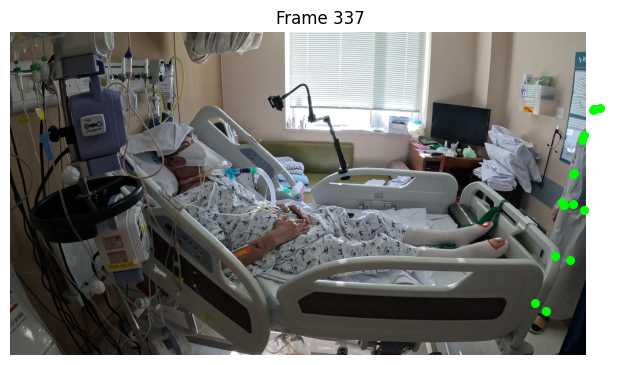

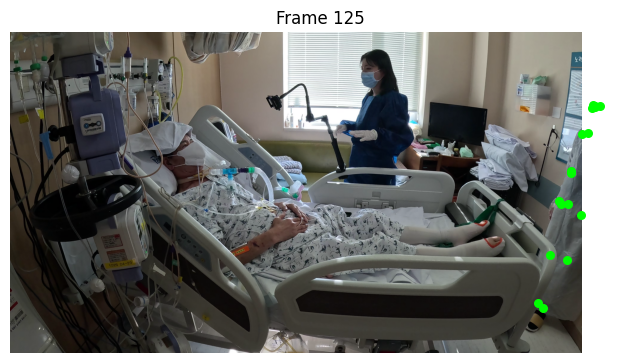

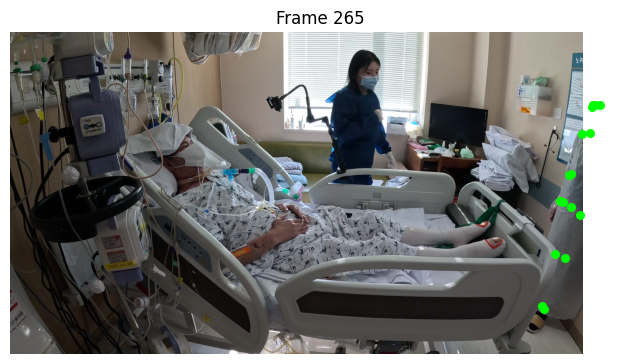

In [33]:
input_json = "../data/test_patient_image/sapiens_fixedbox/M02_VISIT12_하지1_sapiens.json"
input_mp4  = "/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/M02_VISIT12_하지1.MP4"

pose_config = "../sapiens/pose/configs/sapiens_pose/coco/sapiens_0.3b-210e_coco-1024x768.py"
pose_checkpoint = "../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth"
pose_estimator = init_pose_estimator(pose_config, pose_checkpoint, device="cuda:0")

visualize_random_frames_from_json(input_json, input_mp4, pose_estimator, num_samples=3)


In [25]:
import os, cv2, json, warnings, numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils import LOGGER
from mmpose.apis import init_model as init_pose_estimator, inference_topdown
from mmpose.structures import merge_data_samples

warnings.filterwarnings("ignore", category=UserWarning)
LOGGER.setLevel("ERROR")

def run_sapiens_with_yolo_fixedbox_json(
    input_mp4,
    output_dir,
    pose_config,
    pose_checkpoint,
    device="cuda:0",
    duration_calib=30,   # YOLO-pose로 bbox 추출할 구간 (초)
    duration_pose=60,    # pose estimation 실행할 구간 (초)
    margin_ratio=0.2
):
    os.makedirs(output_dir, exist_ok=True)
    basename = os.path.splitext(os.path.basename(input_mp4))[0]
    output_json = os.path.join(output_dir, f"{basename}_sapiens.json")

    # -------------------------
    # 1) YOLOv11-pose로 30초간 bbox 추출 → median bbox 계산
    # -------------------------
    yolo_pose = YOLO("yolo11n-pose.pt")
    cap = cv2.VideoCapture(input_mp4)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_limit = int(min(total_frames, fps * duration_calib))
    bbox_list = []

    for _ in tqdm(range(frame_limit), desc="YOLO-Pose Calibration (BBox)"):
        ret, frame = cap.read()
        if not ret:
            break
        results = yolo_pose(frame, verbose=False)
        for r in results:
            for kp in r.keypoints.xy:
                x_coords = kp[:, 0].cpu().numpy()
                y_coords = kp[:, 1].cpu().numpy()
                if len(x_coords) == 0 or len(y_coords) == 0:
                    continue
                x1, y1, x2, y2 = int(x_coords.min()), int(y_coords.min()), int(x_coords.max()), int(y_coords.max())
                bw, bh = x2 - x1, y2 - y1
                x1 = max(0, int(x1 - bw * margin_ratio))
                y1 = max(0, int(y1 - bh * margin_ratio))
                x2 = min(orig_w, int(x2 + bw * margin_ratio))
                y2 = min(orig_h, int(y2 + bh * margin_ratio))
                bbox_list.append([x1, y1, x2, y2])
    cap.release()

    if not bbox_list:
        raise RuntimeError("YOLOv11-pose로부터 bbox를 얻지 못했습니다.")
    fixed_box = tuple(np.median(np.array(bbox_list), axis=0).astype(int))
    print(f"[INFO] 고정된 BBox: {fixed_box}")

    # -------------------------
    # 2) Sapiens Pose Estimator 초기화
    # -------------------------
    pose_estimator = init_pose_estimator(
        pose_config,
        pose_checkpoint,
        device=device,
        cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False))),
    )

    # joint name 자동 로드
    if "keypoint_info" in pose_estimator.dataset_meta:
        joint_names = [v["name"] for v in pose_estimator.dataset_meta["keypoint_info"].values()]
    elif "keypoint_labels" in pose_estimator.dataset_meta:
        joint_names = pose_estimator.dataset_meta["keypoint_labels"]
    else:
        joint_names = [f"kpt_{i}" for i in range(pose_estimator.cfg.model.head.out_channels)]

    # -------------------------
    # 3) Pose Estimation (고정 bbox, 앞 60초)
    # -------------------------
    cap = cv2.VideoCapture(input_mp4)
    frame_limit = int(min(total_frames, fps * duration_pose))

    all_keypoints = {}

    for frame_idx in tqdm(range(frame_limit), desc="Sapiens Pose Estimation"):
        ret, frame = cap.read()
        if not ret:
            break

        x1, y1, x2, y2 = fixed_box
        bboxes_np = np.array([[x1, y1, x2, y2]], dtype=np.float32)  # (1,4)

        pose_results = inference_topdown(pose_estimator, frame, bboxes_np)
        data_sample  = merge_data_samples(pose_results)

        inst = data_sample.get("pred_instances", None)
        if inst is not None and len(inst.get("keypoints", [])) > 0:
            kpts = inst["keypoints"][0].tolist()  # (K,2)

            # JSON 저장용 dict (좌표만 저장)
            frame_dict = {joint_names[i]: kpts[i] for i in range(len(joint_names))}
            all_keypoints[f"frame_{frame_idx:06d}"] = frame_dict

    cap.release()

    # -------------------------
    # 4) JSON 저장
    # -------------------------
    with open(output_json, "w") as f:
        json.dump(all_keypoints, f, indent=2)

    print(f"[INFO] JSON 저장 완료: {output_json}")


In [26]:
input_mp4 = "/workspace/nas203/ds_RehabilitationMedicineData/data/김원 보산진 연구/M02_VISIT12_하지1.MP4"
pose_config = "../sapiens/pose/configs/sapiens_pose/coco/sapiens_0.3b-210e_coco-1024x768.py"
pose_checkpoint = "../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth"
output_dir = "../data/test_patient_image/sapiens_fixedbox"

run_sapiens_with_yolo_fixedbox_json(
    input_mp4=input_mp4,
    output_dir=output_dir,
    pose_config=pose_config,
    pose_checkpoint=pose_checkpoint,
    device="cuda:0",
    duration_calib=30,
    duration_pose=30
)


YOLO-Pose Calibration (BBox): 100% 899/899 [00:30<00:00, 29.62it/s]


[INFO] 고정된 BBox: (3549, 271, 3840, 2160)
Loads checkpoint by local backend from path: ../sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var



Sapiens Pose Estimation: 100% 899/899 [07:51<00:00,  1.91it/s]

[INFO] JSON 저장 완료: ../data/test_patient_image/sapiens_fixedbox/M02_VISIT12_하지1_sapiens.json
